# Plotting FWI for 2022 for ESOTC

<div class="alert alert-block alert-info">
<b>Note:</b> If you're running this notebook on ATOS using ecinteractive, make sure that you started it with at least 16 GB ram memory, otherwise it will crash at some point.
</div>

In this notebook we calculate and plot the number of days in 2022 where FWI exceded 90th percentile of 1991-2022 climatology.  
At the moment reading of the data is hardcoded, as the files are in Chris' scratch directory.  

First import bunch of stuff:

In [1]:
import xarray as xr
import cartopy as cart
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as colors

In [2]:
ds = xr.open_mfdataset('/scratch/maca/geff-grib-issue/reg_fwi.nc')

I was running out of memory, so for the first go, I slice it to smaller area.  
This is now commented out.  
If you don't have enough memory and still want to run this data, uncomment next cell, then replace ds with small in all the cells below.

In [3]:
#small = ds.sel(latitude=slice(50,35), longitude=slice(10,30))

In [4]:
fwinx = ds.fwinx

# The calculations

First we filter out the time period we want to analyse. Here it is from 1st May 2022 to 30 September 2022.

In [5]:
last_y = ds.sel(time=slice('2022-05-01T12:00:00.000000000','2022-09-30T12:00:00.000000000'))
last_y

<xarray.Dataset>
Dimensions:    (latitude: 214, longitude: 302, time: 153)
Coordinates:
  * longitude  (longitude) float32 -34.88 -34.59 -34.31 ... 49.22 49.5 49.78
  * latitude   (latitude) float32 79.95 79.67 79.39 79.11 ... 20.66 20.37 20.09
  * time       (time) datetime64[ns] 2022-05-01T12:00:00 ... 2022-09-30T12:00:00
Data variables:
    fwinx      (time, latitude, longitude) float32 dask.array<chunksize=(153, 214, 302), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2023-01-30 16:22:07 GMT by grib_to_netcdf-2.30.0: grib_to_n...

Our data has all the days and months for years 1980 to 2022.   
To calculate the climatology we need to filter out the data for May, June, July, August and September for years 1991 to 2020.  
First we select the data from 1991, and then we append the remaining years to that.

In [6]:
mjjas_data = ds.sel(time=slice('1991-05-01', '1991-09-30'))
for year in range(1992, 2021):
    mjjas_data = xr.concat([mjjas_data, ds.sel(time=slice(f'{year}-05-01', f'{year}-09-30'))], dim='time')

Next we calculate 90th percentile over the time dimension.  
Since our data was created by concatenating datasets, it will be chunked over the **time** dimension.  
Quintile calculation won't work if the data is chunked over the dimension on which it is calculated.  
To make sure that the data is not chunked over the dimension, we need to **load** the data.  Be careful when doing this, as it can lead to running out of memory.

In [7]:
mjjas_data = mjjas_data.load()

In [8]:
q=mjjas_data.fwinx.quantile(0.9,dim='time')

/usr/local/apps/python3/3.8.8-01/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


The last thing to count is the number of days in 2022 when the FWI value was bigger than 90th percentile.

In [9]:
ex_count = last_y.fwinx.where(last_y.fwinx>q).groupby('time.year').count(dim='time')
ex_count

<xarray.DataArray 'fwinx' (year: 1, latitude: 214, longitude: 302)>
dask.array<stack, shape=(1, 214, 302), dtype=int64, chunksize=(1, 214, 302), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 -34.88 -34.59 -34.31 ... 49.22 49.5 49.78
  * latitude   (latitude) float32 79.95 79.67 79.39 79.11 ... 20.66 20.37 20.09
    quantile   float64 0.9
  * year       (year) int64 2022

## Plotting
Plotting using cartopy will work on the 2D data. Our calculated dataset has 3 dimensions, latitude, longitude and time. We need to remove the time.  
We can do that by just selecting the year 2022.

In [10]:
ex_count = ex_count.sel(year=2022)

<ipython-input-15-8817eb8d4b85>:2: UserWarning: The default value for the *approx* keyword argument to TransverseMercator will change from True to False after 0.18.
  ax = plt.axes(projection=ccrs.TransverseMercator(32))


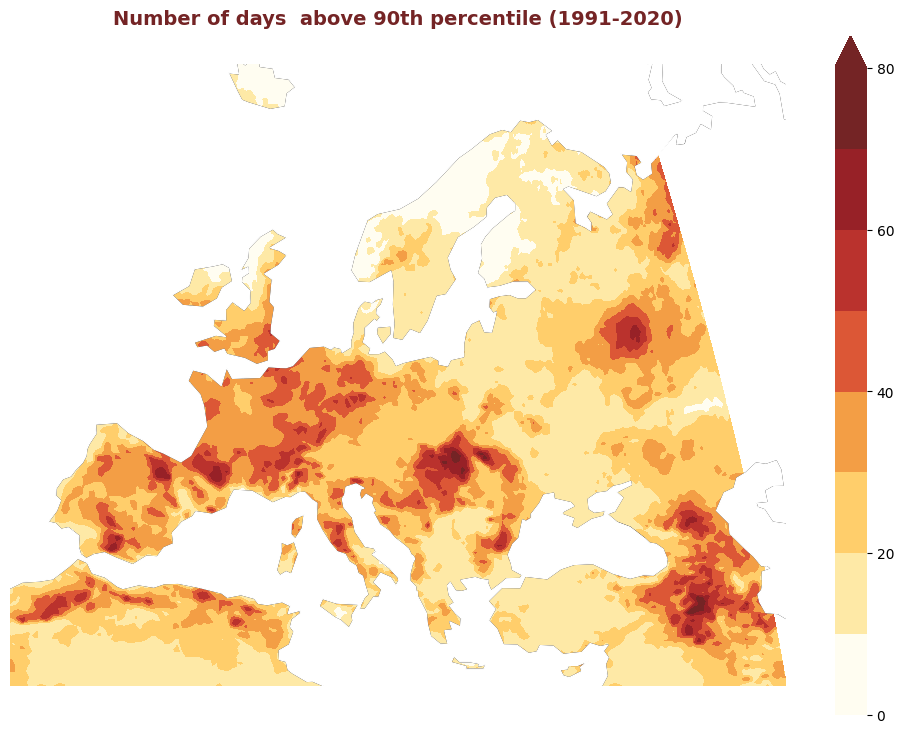

In [15]:
plt.figure(figsize=(10, 10), dpi=100)
ax = plt.axes(projection=ccrs.TransverseMercator(32))

ax.add_feature(cart.feature.OCEAN, zorder=100, edgecolor='#dc5736', color='white')
ax.set_extent ((-10, 50, 34, 70), ccrs.PlateCarree())

red8 = ['#fffdf1', '#fee9a6', '#ffce6b', '#f39e45', '#dc5736', '#ba322d', '#972127', '#742425']
# Create the custom colormap
my_cmap = colors.ListedColormap(red8)

# Specify the number of discrete levels to use in the colormap
bounds = [0, 10, 20, 30, 40, 50,60,70,80]#,90,100]
norm = colors.BoundaryNorm(bounds, my_cmap.N)

# Plot data with contours and shading
img = ex_count.plot.contourf(ax=ax, transform=ccrs.PlateCarree(), cmap=my_cmap, norm=norm, levels=10,
                             add_colorbar=False, add_labels=False)
cbar = plt.colorbar(img, ax=ax, shrink=0.7, ticks=bounds[::2])
cbar.outline.set_visible(False)


ax.coastlines()
ax.set_frame_on(False)
plt.title("Number of days  above 90th percentile (1991-2020)", fontsize=14, fontweight='bold', y=1.05, color='#742425')
plt.tight_layout()
plt.savefig('/home/nen/scripts/ESOTC/2022/over_90perc_europe.png', facecolor='white')